**Week 10: Markovian Langevin Dynamics and Diffusion**

Jannek Schaffert, Frédéric Sonak

This markdown was created with the assistance of ChatGPT, focusing on grammar, spelling, and readability.

**Background**

In this excercise a Langevian Integrator (LE) with Markovian dynamics is implemented.



Importing all libraries used in this code.


In [15]:
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

from numba import njit

import copy
import numpy as np
import scipy as scy
from tqdm import tqdm
import time
# Import tqdm


**Task 1: Implementation**

equation:
$
\vec{v}_{k+1} = \vec{v}_k - \frac{1}{m} \left( \Gamma \vec{v}_k \Delta t - \sqrt{2 \Gamma k_B T \Delta t} \cdot \vec{R}_k \right);
$

with

$
\vec{x}_{k+1} = \vec{x}_k + \vec{v}_k \Delta t
$.

With $k$ denoting the step number, $\Delta t$ the time step length, $U$ the potential energy, $x$ the position, $v$ the velocity, and a friction constant $\Gamma$.




In [54]:

def langevin_integrator(steps, dt, x0, v0, mass, gamma, temp, k_B=1.380649e-23, verbose=False):

    # Start timer
    start_time = time.time()

    # Initialise position and velocity arrays
    positions = np.zeros((steps, len(x0)))
    velocities = np.zeros((steps, len(v0)))

    # Set initial position and velocity
    positions[0] = x0
    velocities[0] = v0 # temperature accounted velocity will be added later on

    # calculate constants outside of loop to remove reduntant calculations
    # speeds up by about 20 % for large loops
    const_1 = gamma * dt / mass
    const_2 = np.sqrt(2 * gamma * k_B * temp * dt) / mass

    # only use the "tqdm for loop" in verbose
    if verbose:
    # Loop over steps with tqdm
        for i in tqdm(range(steps - 1), desc="Running Langevin Integrator", unit="steps"):
            # Generate Gaussian random number around zero with stdv 1
            R = np.random.normal(0, 1, size=x0.shape)

            # Current velocity and position
            v = velocities[i]
            x = positions[i]

            # Update velocity and position
            v_next = v - const_1 * v + const_2 * R
            x_next = x + v_next * dt

            # Store the updated values
            velocities[i + 1] = v_next
            positions[i + 1] = x_next

    else:
        for i in (range(steps - 1)):
            # Generate Gaussian random number around zero with stdv 1
            R = np.random.normal(0, 1, size=x0.shape)

            # Current velocity and position
            v = velocities[i]
            x = positions[i]

            # Update velocity and position
            v_next = v - const_1 * v + const_2 * R
            x_next = x + v_next * dt

            # Store the updated values
            velocities[i + 1] = v_next
            positions[i + 1] = x_next

    # Verbose logging
    if verbose and i % 100 == 0:
        print(f"Step {i}: Position = {x_next}, Velocity = {v_next}")

    # End timer and print elapsed time
    end_time = time.time()
    print(f"Time elapsed: {end_time - start_time} seconds")

    return positions, velocities

**Task 2 - LE Simulation**

A particle with a mass of $m = 18$g/ mol and a starting velocity corresponding to a temperature of $T = 293.15$K in a random direction is assigned to the particle.
The potential energy is set a constant throughout the box. This changes our LE integrator. TO observe this, first we need to rewrite the Langevian equation with potential energy $U$:

$
\vec{v}_{k+1} = \vec{v}_k - \frac{1}{m} \left( \frac{dU}{dx} \Delta t + \vec{v}_k \Gamma \Delta t - \sqrt{2 \Gamma k_B T \Delta t} \cdot \vec{R}_k \right)
$

Since the Potential is set to a constant the equation simplifies to

$
\vec{v}_{k+1} = \vec{v}_k - \frac{1}{m} \left( \vec{v}_k \Gamma \Delta t - \sqrt{2 \Gamma k_B T \Delta t} \cdot \vec{R}_k \right)
$

and

$
\vec{x}_{k+1} = \vec{x}_k + \vec{v}_k \Delta t
$

.


In [55]:
# Example Parameters
steps = 1000000 # 1 Mio
dt = 1.0e-6 # ns
kB = 1.380649e-23
mass = 0.018  # kg/mol
gamma = 50  # Friction constant from sheet kg/(mol ns)
temp = 293.15  # Kelvin

x0 = np.array([0.0, 0.0])  # Initial position (2D) in nm

# initial velocity should be according to a temperature of 293.15 K
def get_velocity_with_temperature(temperature, kB, mass):

    v0_magnitude = np.sqrt((kB * temp)/mass)
    random_angle = np.random.uniform(0, 2 * np.pi)
    v0 = np.array([v0_magnitude * np.cos(random_angle), v0_magnitude * np.sin(random_angle)])  # Initial velocity (2D)
    return v0
v0 = get_velocity_with_temperature(temp, kB, mass)




In [56]:
# Run simulation
positions, velocities = langevin_integrator(steps, dt, x0, v0, mass, gamma, temp, verbose=True)

# just to check the initial velocity
print(f'Initial Velocity: ', velocities[0])


Running Langevin Integrator: 100%|██████████| 999999/999999 [00:17<00:00, 57115.86steps/s]

Time elapsed: 17.546385765075684 seconds
Initial Velocity:  [ 3.42240986e-10 -3.28215079e-10]


From the elapsed time we can see that this simulation is significantly faster than previous MD simulations.

Plotting the position evolution from the simulation for visualisation.

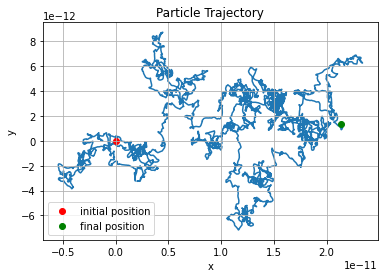

In [40]:

# z order makes sure the initial and final position dots are on top of the trajectory

plt.plot(positions[:, 0], positions[:, 1], zorder=0)
plt.scatter(positions[0,0], positions[0,1], label="initial position", color="red", zorder=1)
plt.scatter(positions[-1,0], positions[-1,1], label="final position", color="green", zorder=1)
plt.title("Particle Trajectory")
plt.xlabel("x")
plt.ylabel("y")
plt.grid()
plt.legend()
plt.show()



**Task 3 - Determination of diffusion coefficient**

The 2D diffusion coefficient is calculated:

$
D(t) = \Delta \vec{x}(t)^2 / 4t
$

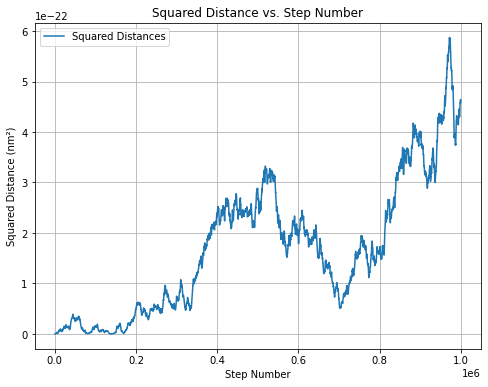

In [41]:
def calculate_distance_squared(positions):
    initial_positions = positions[0,:]
    displacements = positions - initial_positions
    squared_distances = np.sum(displacements ** 2, axis=1)
    return squared_distances

p = calculate_distance_squared(positions)

plt.figure(figsize=(8, 6))
plt.plot(range(len(p)), p, label="Squared Distances")
plt.xlabel("Step Number")
plt.ylabel("Squared Distance (nm²)")
plt.title("Squared Distance vs. Step Number")
plt.grid()
plt.legend()
plt.show()



Due to fluctuations we cannot really get anything out of this. Therefore, we are going to repeat the simulation to calculate averaged squared differences. Thus, we should be able to visualise a trend.

In [42]:
number_of_simulations = 10 # don't go to big, this takes X times the above simulation!

# Array to store squared distances for all simulations
squared_distanced = np.zeros(steps)

for i in tqdm(range(number_of_simulations), desc="Running simulations"):
    x0 = np.array([0.0, 0.0])  # Reset initial position
    v0 = get_velocity_with_temperature(temp, kB, mass)  # Generate initial velocity
    positions, _ = langevin_integrator(steps, dt, x0, v0, mass, gamma, temp, verbose=False)  # Run simulation

    # Calculate squared distance from the origin for this simulation
    squared_distanced = squared_distanced + np.sum(positions ** 2, axis=1)

# Divide by the number of simulations to get the mean
squared_distanced = squared_distanced / number_of_simulations


Time elapsed: 26.82311487197876 seconds
Time elapsed: 28.893540143966675 seconds
Time elapsed: 24.769349098205566 seconds
Time elapsed: 24.77323579788208 seconds
Time elapsed: 24.26915693283081 seconds
Time elapsed: 26.067607879638672 seconds
Time elapsed: 25.273284196853638 seconds
Time elapsed: 26.941720724105835 seconds
Time elapsed: 26.79635190963745 seconds
Time elapsed: 24.57127094268799 seconds


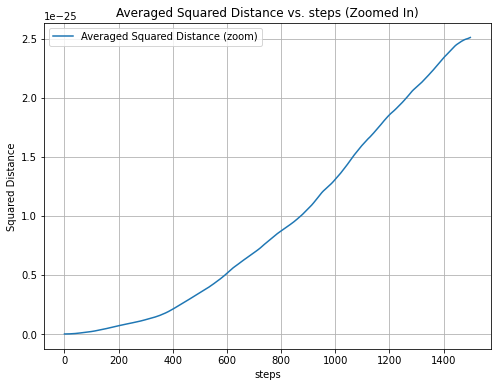

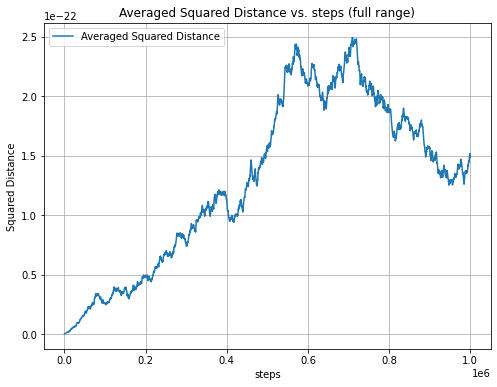

In [44]:

# Plot for very small times
plt.figure(figsize=(8, 6))
plt.plot(squared_distanced[:1500], label="Averaged Squared Distance (zoom)")
plt.xlabel("steps")
plt.ylabel("Squared Distance")
plt.title("Averaged Squared Distance vs. steps (Zoomed In)")
plt.grid()
plt.legend()
plt.show()

# Plot for the entire range
plt.figure(figsize=(8, 6))
plt.plot(squared_distanced, label="Averaged Squared Distance")
plt.xlabel("steps")
plt.ylabel("Squared Distance")
plt.title("Averaged Squared Distance vs. steps (full range)")
plt.grid()
plt.legend()
plt.show()

I think we can see the initial ballistic evolution converging to something linear after about 1500 Steps.

In [45]:
# Calculate D
Ds = squared_distanced[1:] / (4 * np.arange(1, np.shape(squared_distanced)[0]) * dt)

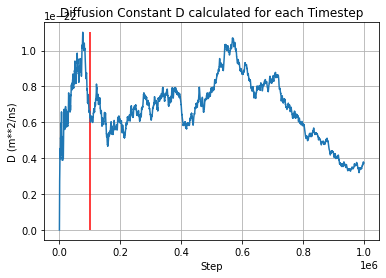

In [52]:
# Plot D
cut = 100000
plt.plot(Ds)
plt.vlines(cut, np.min(Ds), np.max(Ds), color='r')
plt.title('Diffusion Constant D calculated for each Timestep')
plt.grid()
plt.xlabel('Step')
plt.ylabel('D (m**2/ns)')
plt.show()



In [51]:
# Determine Difussion Constant
D = np.mean(Ds[cut:])
print(f'We obtain a Diffusion Constant D = {D:} m*2/ns after a cut of {cut}')

We obtain a Diffusion Constant D = 6.676656180391882e-23 nm*2/ns after a cut of 100000


$
\Gamma = \frac{k_B T}{D}
$
Einstein equation

In [53]:
# Calculate Friction Coefficiant using the einstein equation
gamma_new = kB * temp / D
print(f'We have for gamma (N*ns/(mol*m)):\nInput: {gamma:.3f}\nRcalculated: {gamma_new:.3f}')

We have for gamma (N*ns/(mol*m)):
Input: 50.000
Rcalculated: 60.620


Thats not exactly the same but errors might be due to just 10 simulations. More simulations take too long. One probably has to optimise the code and then do like 1000 simulations.